## Anomaly Detection for NYC Taxi & Limousine Data

In [406]:
import numpy as np
import pandas as pd
import geopandas as gp
from geopandas import GeoDataFrame
import os
from shapely.geometry import Point
from datetime import datetime
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import IsolationForest
from pandas.tseries.holiday import USFederalHolidayCalendar
from mpl_toolkits.mplot3d import Axes3D
#import pickle

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


/home/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'datetime', 'clf', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
proj_folder = os.getcwd()
data_folder_external = proj_folder + '/data'
data_folder_external

'/wingrdp/homedirs/gtp232/machine_learning/anomaly_detection_NYC_transit/data'

## TLC anomaly detection

## Notes 4-22-17
Next steps:
1. would love to look at different areas of the city and see where the anomalies relative to those places
i.e. taxi trips to/from coney island would be interesting / or around MSG - "concert superstorm?"

## Notes 4-26-17
Next steps:
1. add day of week analysis 
2. add more months of data

## Notes 4-28-17
Next steps:
1. account for holidays 
http://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/
2. account for day of the week
3. add another anomaly detection model?

In [4]:
### read in data for 2015
'''
taken from
http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml
NOTE: after june 2016, the data no longer has lat / lons, only has neighborhoods
'''

columns = ['passenger_count', 'trip_distance', 'fare_amount', \
                     'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude',\
                     'pickup_latitude']
tlc_df_raw_total = pd.DataFrame(columns = columns)
for i in range(1,10):
    print i
    tlc_df_raw = pd.read_csv(data_folder_external + '/tlc_yellow_2015_0' + str(i) + '.csv', usecols=['passenger_count', \
                    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude'])
    tlc_df_raw['tpep_pickup_datetime'] = pd.to_datetime(tlc_df_raw['tpep_pickup_datetime'])
    tlc_df_raw['tpep_dropoff_datetime'] = pd.to_datetime(tlc_df_raw['tpep_dropoff_datetime'])
    tlc_df_raw_total = tlc_df_raw_total.append(tlc_df_raw, ignore_index=True)

for i in range(10,13):
    print i
    tlc_df_raw = pd.read_csv(data_folder_external + '/tlc_yellow_2015_' + str(i) + '.csv', usecols=['passenger_count', \
                    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude'])
    tlc_df_raw['tpep_pickup_datetime'] = pd.to_datetime(tlc_df_raw['tpep_pickup_datetime'])
    tlc_df_raw['tpep_dropoff_datetime'] = pd.to_datetime(tlc_df_raw['tpep_dropoff_datetime'])
    tlc_df_raw_total = tlc_df_raw_total.append(tlc_df_raw, ignore_index=True)


1
2
3
4
5
6
7
8
9
10
11
12


In [5]:
len(tlc_df_raw_total)

146112989

In [6]:
tlc_df_raw_total.head()

,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
0,1.0,12.0,0.5,1.0,40.750111,-73.993896,3.25,17.05,2015-01-15 19:23:42,2015-01-15 19:05:39,1.59
1,0.5,14.5,0.5,1.0,40.724243,-74.001648,2.00,17.80,2015-01-10 20:53:28,2015-01-10 20:33:38,3.30
2,0.5,9.5,0.5,1.0,40.802788,-73.963341,0.00,10.80,2015-01-10 20:43:41,2015-01-10 20:33:38,1.80
3,0.5,3.5,0.5,1.0,40.713818,-74.009087,0.00,4.80,2015-01-10 20:35:31,2015-01-10 20:33:39,0.50
4,0.5,15.0,0.5,1.0,40.762428,-73.971176,0.00,16.30,2015-01-10 20:52:58,2015-01-10 20:33:39,3.00


In [6]:
#CANNOT GET THIS TRIP DURATION TO WORK - MOVING ON FOR NOW
#tlc_df['trip_duration'] = pd.Timedelta(tlc_df['tpep_dropoff_datetime_2'] - tlc_df['tpep_pickup_datetime']).seconds / 3600.0
#tlc_df['trip_speed'] = tlc_df.trip_distance / tlc_df.trip_duration

## Clean the data - 
drop all the unreasonable trip entries, such as those that have trip distance in the millions of miles

In [7]:
#only keep trips that have a positive distance less than 100 miles
tlc_df_total = tlc_df_raw_total[(tlc_df_raw_total.trip_distance > 0) & (tlc_df_raw_total.trip_distance < 100)]

#only keep trips that have a positive fare amount less than $500
tlc_df_total = tlc_df_total[(tlc_df_total.fare_amount > 0) & (tlc_df_total.fare_amount < 500)]

#only keep trips that have a positive tip amount less than $1000
tlc_df_total = tlc_df_total[(tlc_df_total.tip_amount >= 0) & (tlc_df_total.tip_amount < 1000)]

In [346]:
len(tlc_df_total) * 1.0 / len(tlc_df_raw_total)

0.9931872175991143

In [343]:
#count the number of taxi trips each day
tlc_df_total['taxi_date'] = tlc_df_total['tpep_pickup_datetime'].dt.date
tlc_df_day_count = tlc_df_total.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_day_count.columns = ['taxi_date', 'taxi_trip_count']

In [344]:
#take the mean of the taxi stats each day
tlc_df_stat_agg = tlc_df_total.groupby(['taxi_date'], as_index=False).mean()
tlc_df_stat_agg.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance
0,2015-01-01,0.270273,12.657806,0.497992,1.809730,39.943048,-72.508607,1.282963,15.247579,3.255304
1,2015-01-02,0.397660,12.064885,0.498283,1.758867,39.959375,-72.536360,1.262980,14.796527,2.963635
2,2015-01-03,0.194821,11.577505,0.498651,1.777010,40.090698,-72.778421,1.273699,14.058896,2.846575
3,2015-01-04,0.189877,12.634198,0.498123,1.722101,40.200017,-72.973559,1.492329,15.445016,3.332494
4,2015-01-05,0.371148,12.149376,0.498688,1.655208,40.032467,-72.664518,1.511471,15.148335,3.033297


In [345]:
tlc_df_by_day = tlc_df_stat_agg.merge(tlc_df_day_count, on='taxi_date')
tlc_df_by_day.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,taxi_trip_count
0,2015-01-01,0.270273,12.657806,0.497992,1.809730,39.943048,-72.508607,1.282963,15.247579,3.255304,378940
1,2015-01-02,0.397660,12.064885,0.498283,1.758867,39.959375,-72.536360,1.262980,14.796527,2.963635,343093
2,2015-01-03,0.194821,11.577505,0.498651,1.777010,40.090698,-72.778421,1.273699,14.058896,2.846575,404372
3,2015-01-04,0.189877,12.634198,0.498123,1.722101,40.200017,-72.973559,1.492329,15.445016,3.332494,326536
4,2015-01-05,0.371148,12.149376,0.498688,1.655208,40.032467,-72.664518,1.511471,15.148335,3.033297,360646


In [14]:
tlc_df_by_day['day_of_week'] = tlc_df_by_day.taxi_date.apply(lambda x: x.weekday())

In [15]:
#control for Friday / Saturday nights
tlc_df_by_day['weekend'] = 0
tlc_df_by_day['weekend'][(tlc_df_by_day['day_of_week'] == 4) | (tlc_df_by_day['day_of_week'] == 5)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Add Feature for Holidays

In [16]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True)
holidays.name = 'name'
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
Name: name, dtype: object

In [17]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()

In [18]:
#add holiday dummy variable
tlc_df_by_day['holiday'] = 0
tlc_df_by_day['holiday'][tlc_df_by_day['taxi_date'].isin(holidays_all.index.date)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [407]:
tlc_df_by_day.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,taxi_trip_count,cluster,km_score,outlier,color
26,2015-01-27,0.534315,9.281400,0.499611,1.714553,40.134412,-72.851410,1.241452,11.932300,2.231997,134820,2,5.946016,1,red
358,2015-12-25,0.187647,12.892594,0.498300,1.787423,40.295980,-73.140749,1.317086,15.520742,3.366423,187033,2,2.804393,1,red
270,2015-09-28,0.369048,14.525026,0.498052,1.654874,40.269218,-73.097246,1.975186,18.102169,3.325909,320770,0,2.454395,1,red
25,2015-01-26,0.181358,11.852456,0.498361,1.633555,40.019998,-72.641121,1.551247,14.640396,2.650079,228457,2,2.336159,1,red
9,2015-01-10,0.204225,11.310585,0.499108,1.734337,39.912979,-72.457707,1.405497,13.884081,2.643237,512258,1,2.034055,1,red


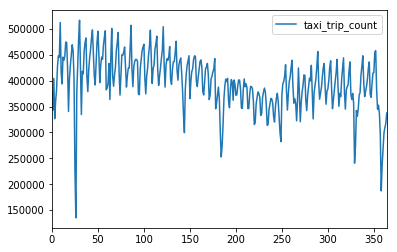

In [20]:
tlc_df_by_day[['taxi_date', 'taxi_trip_count']].plot()

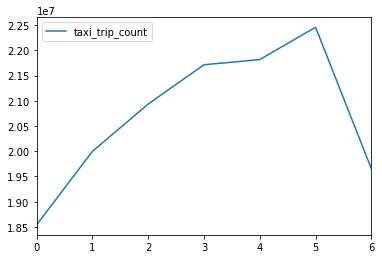

In [21]:
'''
0 is a Monday
1 is tuesday etc etc
'''
tlc_df_by_day_agg = tlc_df_by_day.groupby(['day_of_week'], as_index=False).sum()
tlc_df_by_day_agg[['taxi_trip_count']].plot()

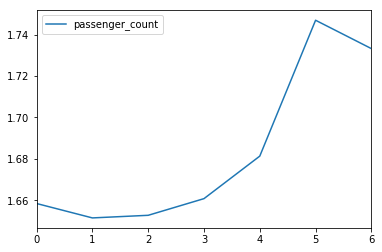

In [22]:
tlc_df_by_day_avg = tlc_df_by_day.groupby(['day_of_week'], as_index=False).mean()
tlc_df_by_day_avg[['passenger_count']].plot()

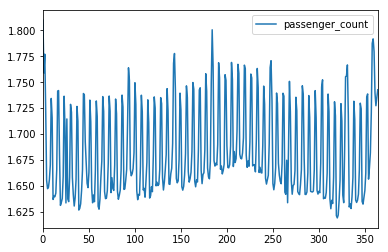

In [23]:
tlc_df_by_day[['taxi_date', 'passenger_count']].plot()

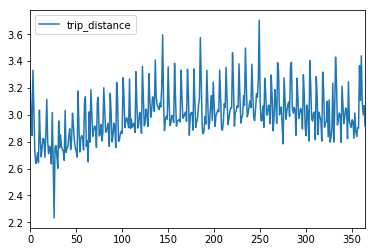

In [24]:
tlc_df_by_day[['taxi_date', 'trip_distance']].plot()

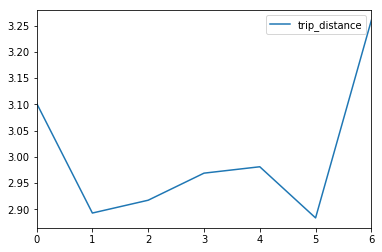

In [25]:
tlc_df_by_day_avg[['trip_distance']].plot()

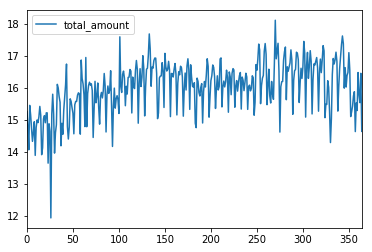

In [26]:
tlc_df_by_day[['taxi_date', 'total_amount']].plot()

## Pickle Main Pandas DFs for easy recovery in the future

In [27]:
# tlc_df_by_day.to_pickle('tlc_df_by_day.pkl')  # where to save it, usually as a .pkl

In [28]:
# tlc_df_total.shape

In [29]:
# n_partitions = 500
# partition_size = len(tlc_df_total) / n_partitions
# for i in range(0,n_partitions+1):
#     print i
#     tlc_df_total_subset = tlc_df_total.iloc[(i*partition_size):((i+1)*partition_size), :]
#     tlc_df_total_subset.to_pickle('tlc_df_total_' + str(i) + '.pkl')  # where to save it, usually as a .pkl

## Clustering Anomaly Detection

In [30]:
# file = open('tlc_df_by_day.pkl','rb')
# tlc_df_by_day = pickle.load(file)
# file.close()

In [31]:
# tlc_df_by_day.head()

In [349]:
cluster_features = ['total_amount', 'taxi_trip_count']

In [350]:
X = tlc_df_by_day[cluster_features]
X.head(2)

,total_amount,taxi_trip_count
0,15.247579,378940
1,14.796527,343093


### K-Means Cluster Model Anomaly Detection

In [351]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()
    
X.head()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,total_amount,taxi_trip_count
0,-0.926054,-0.362853
1,-1.482893,-1.060577
2,-2.393524,0.132154
3,-0.682311,-1.382841
4,-1.048574,-0.718927


In [352]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.389747416886
For n_clusters =3, the average silhouette_score is :0.402972010955
For n_clusters =4, the average silhouette_score is :0.369100098474
For n_clusters =5, the average silhouette_score is :0.328938356873
For n_clusters =6, the average silhouette_score is :0.338600459735
For n_clusters =7, the average silhouette_score is :0.352476091095
For n_clusters =8, the average silhouette_score is :0.365728403493


In [353]:
n=3
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [354]:
tlc_df_by_day['cluster'] = res.cluster
tlc_df_by_day['km_score'] = res.score
tlc_df_by_day['outlier'] = 0
tlc_df_by_day.sort_values("km_score",ascending=False, inplace=True)

In [355]:
tlc_df_by_day['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [356]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

tlc_df_by_day = tlc_df_by_day.assign(color=tlc_df_by_day.apply(set_color, axis=1))

In [357]:
X.head()

,total_amount,taxi_trip_count
0,-0.926054,-0.362853
1,-1.482893,-1.060577
2,-2.393524,0.132154
3,-0.682311,-1.382841
4,-1.048574,-0.718927


In [358]:
tlc_df_by_day.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,taxi_trip_count,cluster,km_score,outlier,color
26,2015-01-27,0.534315,9.281400,0.499611,1.714553,40.134412,-72.851410,1.241452,11.932300,2.231997,134820,2,5.946016,1,red
358,2015-12-25,0.187647,12.892594,0.498300,1.787423,40.295980,-73.140749,1.317086,15.520742,3.366423,187033,2,2.804393,1,red
270,2015-09-28,0.369048,14.525026,0.498052,1.654874,40.269218,-73.097246,1.975186,18.102169,3.325909,320770,0,2.454395,1,red
25,2015-01-26,0.181358,11.852456,0.498361,1.633555,40.019998,-72.641121,1.551247,14.640396,2.650079,228457,2,2.336159,1,red
9,2015-01-10,0.204225,11.310585,0.499108,1.734337,39.912979,-72.457707,1.405497,13.884081,2.643237,512258,1,2.034055,1,red


In [359]:
tlc_df_by_day_w_z_scores = tlc_df_by_day.merge(X, left_index=True, right_index=True)

In [360]:
tlc_df_by_day_w_z_scores.sort_values("km_score",ascending=False, inplace=True)
tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x',\
                                    'total_amount_y', 'taxi_trip_count_y']].head(15)

,taxi_date,km_score,total_amount_x,taxi_trip_count_x,total_amount_y,taxi_trip_count_y
26,2015-01-27,5.946016,11.932300,134820,-5.018880,-5.114389
358,2015-12-25,2.804393,15.520742,187033,-0.588825,-4.098119
270,2015-09-28,2.454395,18.102169,320770,2.598035,-1.495070
25,2015-01-26,2.336159,14.640396,228457,-1.675642,-3.291845
9,2015-01-10,2.034055,13.884081,512258,-2.609339,2.232040
30,2015-01-31,2.025240,13.955886,516806,-2.520694,2.320562
330,2015-11-27,1.997068,14.284729,273491,-2.114726,-2.415306
23,2015-01-24,1.888217,13.641632,457763,-2.908650,1.171353
359,2015-12-26,1.874640,15.284123,237105,-0.880939,-3.123521
184,2015-07-04,1.868617,14.749383,252645,-1.541094,-2.821051


In [361]:
tlc_df_by_day_w_z_scores.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount_x,trip_distance,taxi_trip_count_x,cluster,km_score,outlier,color,total_amount_y,taxi_trip_count_y
26,2015-01-27,0.534315,9.281400,0.499611,1.714553,40.134412,-72.851410,1.241452,11.932300,2.231997,134820,2,5.946016,1,red,-5.018880,-5.114389
358,2015-12-25,0.187647,12.892594,0.498300,1.787423,40.295980,-73.140749,1.317086,15.520742,3.366423,187033,2,2.804393,1,red,-0.588825,-4.098119
270,2015-09-28,0.369048,14.525026,0.498052,1.654874,40.269218,-73.097246,1.975186,18.102169,3.325909,320770,0,2.454395,1,red,2.598035,-1.495070
25,2015-01-26,0.181358,11.852456,0.498361,1.633555,40.019998,-72.641121,1.551247,14.640396,2.650079,228457,2,2.336159,1,red,-1.675642,-3.291845
9,2015-01-10,0.204225,11.310585,0.499108,1.734337,39.912979,-72.457707,1.405497,13.884081,2.643237,512258,1,2.034055,1,red,-2.609339,2.232040


In [363]:
z_score = tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'total_amount_y', 'taxi_trip_count_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('tlc_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [364]:
cluster_features

['total_amount', 'taxi_trip_count']

In [365]:
KM.cluster_centers_

array([[ 0.69263768,  0.05202861],
       [-1.03401574,  0.9452845 ],
       [-0.46035814, -1.29666947]])

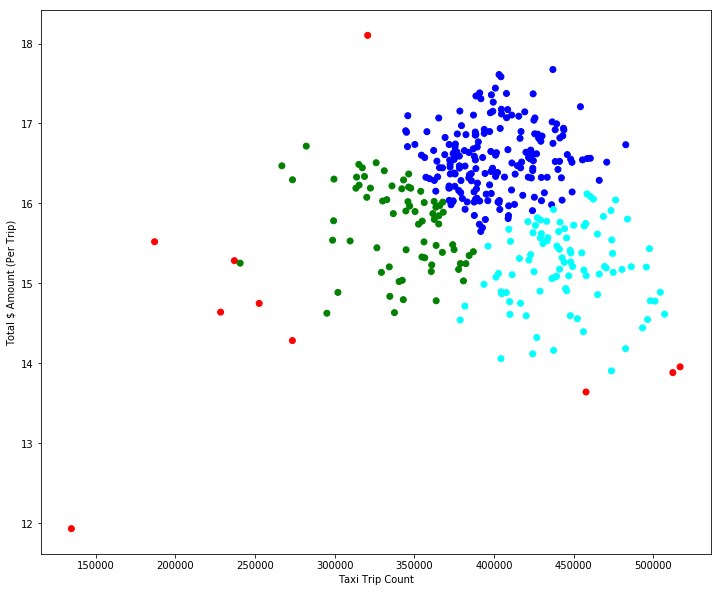

In [408]:
fig = plt.figure(figsize=(12,10))
#ax = Axes2D(fig)

plt.scatter(tlc_df_by_day.taxi_trip_count, tlc_df_by_day.total_amount, c=tlc_df_by_day.color)
plt.xlabel('Taxi Trip Count')
plt.ylabel('Total $ Amount (Per Trip)')
# set x ticks and labels
#plt.set_xticks(range(-2, 3, 1))
# change fontsize
#for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Isolation Anomaly Detection

### Isolation Forest Anomaly Detection

In [368]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [369]:
z_score['decision_function'] = clf.decision_function(X)

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [370]:
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('tlc_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## January 18 has high payments for some reason... investigate

In [371]:
df_1_18 = tlc_df_total[tlc_df_total.taxi_date == datetime.date(2015,1,18)]

In [372]:
df_1_18.sort_values(by='total_amount', ascending=False).head()

,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,taxi_date
5900871,606.12,82.0,0.5,1.0,40.758495,-73.982208,0.00,688.92,2015-01-18 02:56:05,2015-01-18 02:39:09,10.00,2015-01-18
5802097,0.00,350.0,0.5,1.0,40.644112,-73.790398,75.13,451.59,2015-01-18 18:30:54,2015-01-18 16:41:09,65.45,2015-01-18
5348432,0.00,325.0,0.0,1.0,40.660809,-73.805481,25.00,360.96,2015-01-18 16:45:23,2015-01-18 14:55:34,75.63,2015-01-18
961472,0.00,9.5,0.5,2.0,40.757351,-73.972145,350.00,360.30,2015-01-18 13:55:38,2015-01-18 13:42:14,1.20,2015-01-18
3392622,0.00,297.0,0.0,2.0,40.642254,-73.789291,0.00,314.38,2015-01-18 13:30:23,2015-01-18 11:16:31,77.70,2015-01-18


## Look at specific areas and see what times / dates around there are anomalies
### Madison Square Gardens (40.750556, -73.993611)

In [373]:
latlon_list = [40.750556, -73.993611]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
tlc_df_total_subset = tlc_df_total[(tlc_df_total.pickup_latitude > (latlon_list[0] - 0.005)) & (tlc_df_total.pickup_latitude < (latlon_list[0] + 0.005))]
tlc_df_total_subset = tlc_df_total_subset[(tlc_df_total_subset.pickup_longitude > (latlon_list[1] - 0.005)) & (tlc_df_total_subset.pickup_longitude < (latlon_list[1] + 0.005))]

In [374]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(tlc_df_total_subset.pickup_longitude, tlc_df_total_subset.pickup_latitude)]

In [375]:
crs = {'init': 'epsg:4326'}
tlc_df_total_gp = GeoDataFrame(tlc_df_total_subset, crs=crs, geometry=geometry)

In [376]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [377]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.98861100000001 40.750556, -73.98..."


In [378]:
# only keep points within MSG buffer
tlc_df_total_gp_subset = tlc_df_total_gp[tlc_df_total_gp.geometry.intersects(MSG_gp.geometry[0])]

In [379]:
tlc_df_total_gp_subset.head()

,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,taxi_date,geometry
0,1.0,12.0,0.5,1.0,40.750111,-73.993896,3.25,17.05,2015-01-15 19:23:42,2015-01-15 19:05:39,1.59,2015-01-15,POINT (-73.993896484375 40.7501106262207)
11,0.5,7.5,0.5,1.0,40.751419,-73.993782,1.00,9.80,2015-01-10 20:43:26,2015-01-10 20:33:41,1.10,2015-01-10,POINT (-73.99378204345702 40.75141906738281)
26,1.0,9.0,0.5,1.0,40.750080,-73.991127,0.00,10.80,2015-01-15 19:16:18,2015-01-15 19:05:42,1.53,2015-01-15,POINT (-73.99112701416014 40.75008010864258)
64,0.0,7.0,0.5,1.0,40.750809,-73.990952,1.40,9.20,2015-01-04 13:53:17,2015-01-04 13:44:52,1.14,2015-01-04,POINT (-73.99095153808595 40.75080871582031)
89,0.0,8.5,0.5,1.0,40.751350,-73.994003,0.00,9.30,2015-01-15 14:10:24,2015-01-15 14:00:45,1.20,2015-01-15,POINT (-73.99400329589844 40.75135040283203)


In [380]:
tlc_df_total_gp_subset['hour'] = tlc_df_total_gp_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [381]:
#subset to 3pm - midnight hours (to only capture relevant hours)
#tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 15) & (tlc_df_total_gp_subset.hour <= 23)]

In [382]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_count = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_MSG_count.columns = ['taxi_date', 'taxi_trip_count']
tlc_df_MSG_count.head()

,taxi_date,taxi_trip_count
0,2015-01-01,12623
1,2015-01-02,15700
2,2015-01-03,16950
3,2015-01-04,15292
4,2015-01-05,15399


In [383]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_mean = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False).mean()
tlc_df_MSG_mean.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,hour
0,2015-01-01,0.234057,11.652141,0.496633,1.798146,40.750435,-73.992884,1.118746,14.025259,2.789937,12.066466
1,2015-01-02,0.370924,10.948408,0.498726,1.741401,40.750415,-73.992797,0.978538,13.242994,2.319040,14.653822
2,2015-01-03,0.161622,11.135653,0.497788,1.758230,40.750432,-73.992702,1.026978,13.281011,2.356577,14.863658
3,2015-01-04,0.178165,11.247973,0.497580,1.668716,40.750435,-73.992910,1.237116,13.637166,2.627132,14.569252
4,2015-01-05,0.320281,10.328430,0.498831,1.600104,40.750485,-73.992823,1.159662,12.749002,2.253935,12.898175


In [384]:
tlc_df_MSG_by_day_hour = tlc_df_MSG_count.merge(tlc_df_MSG_mean, on=['taxi_date'])
tlc_df_MSG_by_day_hour.head()

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,hour
0,2015-01-01,12623,0.234057,11.652141,0.496633,1.798146,40.750435,-73.992884,1.118746,14.025259,2.789937,12.066466
1,2015-01-02,15700,0.370924,10.948408,0.498726,1.741401,40.750415,-73.992797,0.978538,13.242994,2.319040,14.653822
2,2015-01-03,16950,0.161622,11.135653,0.497788,1.758230,40.750432,-73.992702,1.026978,13.281011,2.356577,14.863658
3,2015-01-04,15292,0.178165,11.247973,0.497580,1.668716,40.750435,-73.992910,1.237116,13.637166,2.627132,14.569252
4,2015-01-05,15399,0.320281,10.328430,0.498831,1.600104,40.750485,-73.992823,1.159662,12.749002,2.253935,12.898175


In [385]:
tlc_df_MSG_by_day_hour['day_of_week'] = tlc_df_MSG_by_day_hour.taxi_date.apply(lambda x: x.weekday())

In [386]:
#control for Friday / Saturday nights
tlc_df_MSG_by_day_hour['weekend'] = 0
tlc_df_MSG_by_day_hour['weekend'][(tlc_df_MSG_by_day_hour['day_of_week'] == 4) | (tlc_df_MSG_by_day_hour['day_of_week'] == 5)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [387]:
#add holiday dummy variable
tlc_df_MSG_by_day_hour['holiday'] = 0
tlc_df_MSG_by_day_hour['holiday'][tlc_df_MSG_by_day_hour['taxi_date'].isin(holidays_all.index.date)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


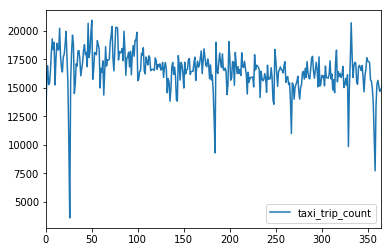

In [388]:
tlc_df_MSG_by_day_hour[['taxi_date', 'taxi_trip_count']].plot()

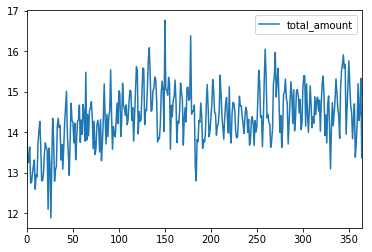

In [389]:
tlc_df_MSG_by_day_hour[['taxi_date', 'total_amount']].plot()

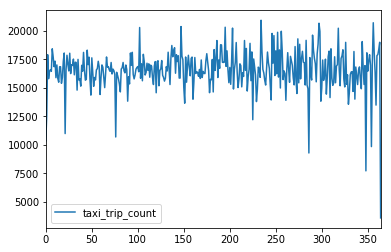

In [390]:
tlc_agg = tlc_df_MSG_by_day_hour.groupby(['hour'], as_index=False).sum()
tlc_agg[['taxi_trip_count']].plot()

In [391]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

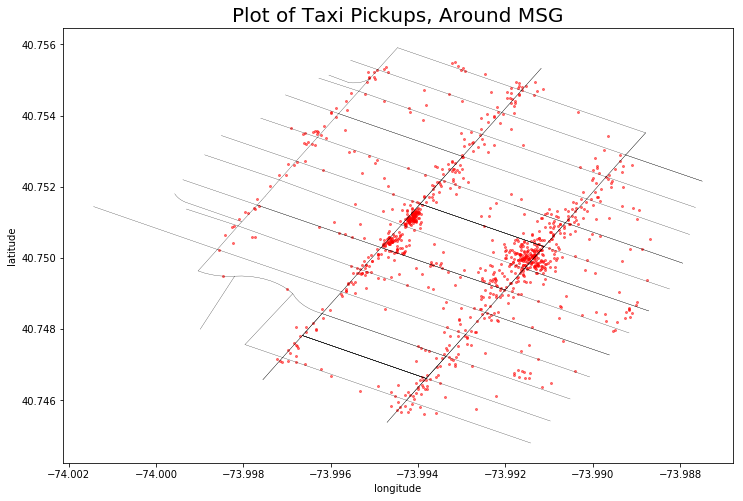

In [392]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = tlc_df_total_gp_subset.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [393]:
tlc_df_total_gp_subset.head()

,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,taxi_date,geometry,hour
0,1.0,12.0,0.5,1.0,40.750111,-73.993896,3.25,17.05,2015-01-15 19:23:42,2015-01-15 19:05:39,1.59,2015-01-15,POINT (-73.993896484375 40.7501106262207),19
11,0.5,7.5,0.5,1.0,40.751419,-73.993782,1.00,9.80,2015-01-10 20:43:26,2015-01-10 20:33:41,1.10,2015-01-10,POINT (-73.99378204345702 40.75141906738281),20
26,1.0,9.0,0.5,1.0,40.750080,-73.991127,0.00,10.80,2015-01-15 19:16:18,2015-01-15 19:05:42,1.53,2015-01-15,POINT (-73.99112701416014 40.75008010864258),19
64,0.0,7.0,0.5,1.0,40.750809,-73.990952,1.40,9.20,2015-01-04 13:53:17,2015-01-04 13:44:52,1.14,2015-01-04,POINT (-73.99095153808595 40.75080871582031),13
89,0.0,8.5,0.5,1.0,40.751350,-73.994003,0.00,9.30,2015-01-15 14:10:24,2015-01-15 14:00:45,1.20,2015-01-15,POINT (-73.99400329589844 40.75135040283203),14


In [394]:
X = tlc_df_MSG_by_day_hour[cluster_features]
X.head(2)

,total_amount,taxi_trip_count
0,14.025259,12623
1,13.242994,15700


In [395]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [396]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [397]:
tlc_df_MSG_by_day_hour['decision_function'] = clf.decision_function(X)

In [398]:
tlc_df_MSG_by_day_hour.sort_values(by='decision_function').head(10)

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,hour,day_of_week,weekend,holiday,decision_function
26,2015-01-27,3599,0.540156,9.298864,0.499444,1.718255,40.750558,-73.992998,1.165582,11.889330,2.206099,17.396777,1,0,0,-0.207831
184,2015-07-04,9292,0.181877,10.633475,0.498547,1.740099,40.750523,-73.992691,1.037090,12.804399,2.509267,13.957275,5,1,1,-0.183371
25,2015-01-26,10358,0.181454,10.734186,0.498504,1.605040,40.750455,-73.992792,1.357831,13.219261,2.111629,10.119328,0,0,0,-0.152979
357,2015-12-24,10696,0.360789,10.925206,0.497709,1.698111,40.750516,-73.992775,1.116998,13.386415,2.444831,13.223168,3,0,1,-0.145098
358,2015-12-25,7725,0.197799,11.336958,0.497735,1.716246,40.750489,-73.992858,1.195188,13.724594,2.680350,14.889968,4,1,1,-0.133813
183,2015-07-03,12208,0.229030,10.850224,0.497665,1.706832,40.750409,-73.992841,1.085757,13.147170,2.458297,13.609682,4,1,1,-0.129236
46,2015-02-16,20667,0.177916,10.494484,0.498355,1.680215,40.750522,-73.992832,1.306227,12.940994,2.337091,14.010984,0,0,1,-0.122500
150,2015-05-31,14984,0.206287,13.915528,0.497564,1.673251,40.750348,-73.992935,1.660047,16.761441,2.797229,14.028764,6,0,0,-0.117440
9,2015-01-10,18991,0.174109,10.425721,0.498736,1.724343,40.750419,-73.992807,1.087926,12.597520,2.196853,14.250066,5,1,0,-0.113668
329,2015-11-26,9852,0.253502,11.619671,0.497006,1.702395,40.750538,-73.993047,1.250675,14.115899,2.769345,15.062221,3,0,1,-0.106591


### K-Means Cluster Model Anomaly Detection

In [399]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.332759691532
For n_clusters =3, the average silhouette_score is :0.360622304528
For n_clusters =4, the average silhouette_score is :0.370832077074
For n_clusters =5, the average silhouette_score is :0.35637887774
For n_clusters =6, the average silhouette_score is :0.319486520169
For n_clusters =7, the average silhouette_score is :0.311896332996
For n_clusters =8, the average silhouette_score is :0.325261026919


In [400]:
n=2
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [401]:
tlc_df_MSG_by_day_hour['cluster'] = res.cluster
tlc_df_MSG_by_day_hour['km_score'] = res.score
tlc_df_MSG_by_day_hour['outlier'] = 0
tlc_df_MSG_by_day_hour.sort_values("km_score",ascending=False, inplace=True)

In [402]:
tlc_df_MSG_by_day_hour['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [403]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

tlc_df_MSG_by_day_hour = tlc_df_MSG_by_day_hour.assign(color=tlc_df_MSG_by_day_hour.apply(set_color, axis=1))

In [404]:
tlc_df_MSG_by_day_hour.head()

,taxi_date,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,hour,day_of_week,weekend,holiday,decision_function,cluster,km_score,outlier,color
26,2015-01-27,3599,0.540156,9.298864,0.499444,1.718255,40.750558,-73.992998,1.165582,11.889330,2.206099,17.396777,1,0,0,-0.207831,1,7.544423,1,red
358,2015-12-25,7725,0.197799,11.336958,0.497735,1.716246,40.750489,-73.992858,1.195188,13.724594,2.680350,14.889968,4,1,1,-0.133813,1,4.761772,1,red
184,2015-07-04,9292,0.181877,10.633475,0.498547,1.740099,40.750523,-73.992691,1.037090,12.804399,2.509267,13.957275,5,1,1,-0.183371,1,4.077741,1,red
329,2015-11-26,9852,0.253502,11.619671,0.497006,1.702395,40.750538,-73.993047,1.250675,14.115899,2.769345,15.062221,3,0,1,-0.106591,1,3.609639,1,red
25,2015-01-26,10358,0.181454,10.734186,0.498504,1.605040,40.750455,-73.992792,1.357831,13.219261,2.111629,10.119328,0,0,0,-0.152979,1,3.342638,1,red


In [405]:
tlc_df_by_day_w_z_scores = tlc_df_MSG_by_day_hour.merge(X, left_index=True, right_index=True)
z_score = tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'total_amount_y', 'taxi_trip_count_y', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('MSG_clustered_by_day_w_z_scores.csv')

KeyError: "['holiday_x' 'weekend_x' 'holiday_y' 'weekend_y'] not in index"

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.taxi_trip_count, X.total_amount, X.weekend, c=tlc_df_MSG_by_day_hour.color)
ax.set_xlabel('Taxi Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-8, 4, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### staten island ferry terminal (Whitehall between state & FDR) (40.702095, -74.012782)

In [ ]:
latlon_list = [40.702095, -74.012782]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
tlc_df_total_subset = tlc_df_total[(tlc_df_total.pickup_latitude > (latlon_list[0] - 0.005)) & (tlc_df_total.pickup_latitude < (latlon_list[0] + 0.005))]
tlc_df_total_subset = tlc_df_total_subset[(tlc_df_total_subset.pickup_longitude > (latlon_list[1] - 0.005)) & (tlc_df_total_subset.pickup_longitude < (latlon_list[1] + 0.005))]

In [ ]:
len(tlc_df_total_subset)

In [ ]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(tlc_df_total_subset.pickup_longitude, tlc_df_total_subset.pickup_latitude)]
tlc_df_total_subset = tlc_df_total_subset.drop(['pickup_latitude', 'pickup_longitude'], axis=1)

In [ ]:
crs = {'init': 'epsg:4326'}
tlc_df_total_gp = GeoDataFrame(tlc_df_total_subset, crs=crs, geometry=geometry)

In [ ]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [ ]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

In [ ]:
# only keep points within MSG buffer
tlc_df_total_gp_subset = tlc_df_total_gp[tlc_df_total_gp.geometry.intersects(MSG_gp.geometry[0])]

In [ ]:
tlc_df_total_gp_subset['hour'] = tlc_df_total_gp_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

In [ ]:
#subset to 6am or greater hours (to only capture relevant hours)
tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 6)]

In [ ]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_count = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_MSG_count.columns = ['taxi_date', 'taxi_trip_count']
tlc_df_MSG_count.head()

In [ ]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_mean = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False).mean()
tlc_df_MSG_mean.head()

In [ ]:
tlc_df_MSG_by_day_hour = tlc_df_MSG_count.merge(tlc_df_MSG_mean, on=['taxi_date'])
tlc_df_MSG_by_day_hour.head()

In [ ]:
tlc_df_MSG_by_day_hour['day_of_week'] = tlc_df_MSG_by_day_hour.taxi_date.apply(lambda x: x.weekday())

In [ ]:
#control for Friday / Saturday nights
tlc_df_MSG_by_day_hour['weekend'] = 0
tlc_df_MSG_by_day_hour['weekend'][(tlc_df_MSG_by_day_hour['day_of_week'] == 4) | (tlc_df_MSG_by_day_hour['day_of_week'] == 5)] = 1

In [ ]:
#add holiday dummy variable
tlc_df_MSG_by_day_hour['holiday'] = 0
tlc_df_MSG_by_day_hour['holiday'][tlc_df_MSG_by_day_hour['taxi_date'].isin(holidays_all.index.date)] = 1

In [ ]:
tlc_df_MSG_by_day_hour[['taxi_date', 'taxi_trip_count']].plot()

In [ ]:
tlc_agg = tlc_df_MSG_by_day_hour.groupby(['hour'], as_index=False).sum()
tlc_agg[['taxi_trip_count']].plot()

In [ ]:
# only keep points within buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [ ]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = tlc_df_total_gp_subset.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around Ferry Terminal", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## Ferry Terminal anomaly analysis (isolation forest)

In [ ]:
X = tlc_df_MSG_by_day_hour[cluster_features]
X.head(2)

In [ ]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

In [ ]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [ ]:
tlc_df_MSG_by_day_hour['decision_function'] = clf.decision_function(X)


In [ ]:
tlc_df_MSG_by_day_hour.sort_values(by='decision_function').head(10)

### K-Means Cluster Model Anomaly Detection

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

In [ ]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [ ]:
tlc_df_MSG_by_day_hour['cluster'] = res.cluster
tlc_df_MSG_by_day_hour['km_score'] = res.score
tlc_df_MSG_by_day_hour['outlier'] = 0
tlc_df_MSG_by_day_hour.sort_values("km_score",ascending=False, inplace=True)

In [ ]:
tlc_df_MSG_by_day_hour['outlier'][:10] = 1 

In [ ]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

tlc_df_MSG_by_day_hour = tlc_df_MSG_by_day_hour.assign(color=tlc_df_MSG_by_day_hour.apply(set_color, axis=1))

In [ ]:
tlc_df_MSG_by_day_hour.head()

In [ ]:
tlc_df_by_day_w_z_scores = tlc_df_MSG_by_day_hour.merge(X, left_index=True, right_index=True)
z_score = tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'total_amount_y', 'taxi_trip_count_y', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('ferry_terminal_clustered_by_day_w_z_scores.csv')

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.taxi_trip_count, X.total_amount, X.weekend, c=tlc_df_MSG_by_day_hour.color)
ax.set_xlabel('Taxi Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-4, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### St. Patricks Cathedral (40.758477, -73.976223)

In [ ]:
latlon_list = [40.758477, -73.976223]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
tlc_df_total_subset = tlc_df_total[(tlc_df_total.pickup_latitude > (latlon_list[0] - 0.005)) & (tlc_df_total.pickup_latitude < (latlon_list[0] + 0.005))]
tlc_df_total_subset = tlc_df_total_subset[(tlc_df_total_subset.pickup_longitude > (latlon_list[1] - 0.005)) & (tlc_df_total_subset.pickup_longitude < (latlon_list[1] + 0.005))]

In [ ]:
len(tlc_df_total_subset)

In [ ]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(tlc_df_total_subset.pickup_longitude, tlc_df_total_subset.pickup_latitude)]
tlc_df_total_subset = tlc_df_total_subset.drop(['pickup_latitude', 'pickup_longitude'], axis=1)

In [ ]:
crs = {'init': 'epsg:4326'}
tlc_df_total_gp = GeoDataFrame(tlc_df_total_subset, crs=crs, geometry=geometry)

In [ ]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [ ]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

In [ ]:
# only keep points within MSG buffer
tlc_df_total_gp_subset = tlc_df_total_gp[tlc_df_total_gp.geometry.intersects(MSG_gp.geometry[0])]

In [ ]:
tlc_df_total_gp_subset['hour'] = tlc_df_total_gp_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

In [ ]:
#subset to 6am or greater hours (to only capture relevant hours)
tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 6)]

In [ ]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_count = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_MSG_count.columns = ['taxi_date', 'taxi_trip_count']
tlc_df_MSG_count.head()

In [ ]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_mean = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False).mean()
tlc_df_MSG_mean.head()

In [ ]:
tlc_df_MSG_by_day_hour = tlc_df_MSG_count.merge(tlc_df_MSG_mean, on=['taxi_date'])
tlc_df_MSG_by_day_hour.head()

In [ ]:
tlc_df_MSG_by_day_hour['day_of_week'] = tlc_df_MSG_by_day_hour.taxi_date.apply(lambda x: x.weekday())

In [ ]:
#control for Friday / Saturday nights
tlc_df_MSG_by_day_hour['weekend'] = 0
tlc_df_MSG_by_day_hour['weekend'][(tlc_df_MSG_by_day_hour['day_of_week'] == 4) | (tlc_df_MSG_by_day_hour['day_of_week'] == 5)] = 1

In [ ]:
#add holiday dummy variable
tlc_df_MSG_by_day_hour['holiday'] = 0
tlc_df_MSG_by_day_hour['holiday'][tlc_df_MSG_by_day_hour['taxi_date'].isin(holidays_all.index.date)] = 1

In [ ]:
tlc_df_MSG_by_day_hour[['taxi_date', 'taxi_trip_count']].plot()

In [ ]:
tlc_agg = tlc_df_MSG_by_day_hour.groupby(['hour'], as_index=False).sum()
tlc_agg[['taxi_trip_count']].plot()

In [ ]:
# only keep points within buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [ ]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = tlc_df_total_gp_subset.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around St. Patricks Cathedral", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## Ferry Terminal anomaly analysis (isolation forest)

In [ ]:
X = tlc_df_MSG_by_day_hour[cluster_features]
X.head(2)

In [ ]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

In [ ]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [ ]:
tlc_df_MSG_by_day_hour['decision_function'] = clf.decision_function(X)

In [ ]:
tlc_df_MSG_by_day_hour.sort_values(by='decision_function').head(10)

### K-Means Cluster Model Anomaly Detection

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

In [ ]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [ ]:
tlc_df_MSG_by_day_hour['cluster'] = res.cluster
tlc_df_MSG_by_day_hour['km_score'] = res.score
tlc_df_MSG_by_day_hour['outlier'] = 0
tlc_df_MSG_by_day_hour.sort_values("km_score",ascending=False, inplace=True)

In [ ]:
tlc_df_MSG_by_day_hour['outlier'][:10] = 1 

In [ ]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

tlc_df_MSG_by_day_hour = tlc_df_MSG_by_day_hour.assign(color=tlc_df_MSG_by_day_hour.apply(set_color, axis=1))

In [ ]:
tlc_df_MSG_by_day_hour.head()

In [ ]:
tlc_df_by_day_w_z_scores = tlc_df_MSG_by_day_hour.merge(X, left_index=True, right_index=True)
z_score = tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'total_amount_y', 'taxi_trip_count_y', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('Patricks_clustered_by_day_w_z_scores.csv')

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.taxi_trip_count, X.total_amount, X.weekend, c=tlc_df_MSG_by_day_hour.color)
ax.set_xlabel('Taxi Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-4, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### Metropolitan Opera (40.772567, -73.984089)

In [ ]:
latlon_list = [40.772567, -73.984089]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
tlc_df_total_subset = tlc_df_total[(tlc_df_total.pickup_latitude > (latlon_list[0] - 0.005)) & (tlc_df_total.pickup_latitude < (latlon_list[0] + 0.005))]
tlc_df_total_subset = tlc_df_total_subset[(tlc_df_total_subset.pickup_longitude > (latlon_list[1] - 0.005)) & (tlc_df_total_subset.pickup_longitude < (latlon_list[1] + 0.005))]

In [ ]:
len(tlc_df_total_subset)

In [ ]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(tlc_df_total_subset.pickup_longitude, tlc_df_total_subset.pickup_latitude)]
tlc_df_total_subset = tlc_df_total_subset.drop(['pickup_latitude', 'pickup_longitude'], axis=1)

In [ ]:
crs = {'init': 'epsg:4326'}
tlc_df_total_gp = GeoDataFrame(tlc_df_total_subset, crs=crs, geometry=geometry)

In [ ]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [ ]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

In [ ]:
# only keep points within MSG buffer
tlc_df_total_gp_subset = tlc_df_total_gp[tlc_df_total_gp.geometry.intersects(MSG_gp.geometry[0])]

In [ ]:
tlc_df_total_gp_subset['hour'] = tlc_df_total_gp_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

In [ ]:
#subset to 6am or greater hours (to only capture relevant hours)
tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 6)]

In [ ]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_count = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_MSG_count.columns = ['taxi_date', 'taxi_trip_count']
tlc_df_MSG_count.head()

In [ ]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_mean = tlc_df_total_gp_subset.groupby(['taxi_date'], as_index=False).mean()
tlc_df_MSG_mean.head()

In [ ]:
tlc_df_MSG_by_day_hour = tlc_df_MSG_count.merge(tlc_df_MSG_mean, on=['taxi_date'])
tlc_df_MSG_by_day_hour.head()

In [ ]:
tlc_df_MSG_by_day_hour['day_of_week'] = tlc_df_MSG_by_day_hour.taxi_date.apply(lambda x: x.weekday())

In [ ]:
#control for Friday / Saturday nights
tlc_df_MSG_by_day_hour['weekend'] = 0
tlc_df_MSG_by_day_hour['weekend'][(tlc_df_MSG_by_day_hour['day_of_week'] == 4) | (tlc_df_MSG_by_day_hour['day_of_week'] == 5)] = 1

In [ ]:
#add holiday dummy variable
tlc_df_MSG_by_day_hour['holiday'] = 0
tlc_df_MSG_by_day_hour['holiday'][tlc_df_MSG_by_day_hour['taxi_date'].isin(holidays_all.index.date)] = 1

In [ ]:
tlc_df_MSG_by_day_hour[['taxi_date', 'taxi_trip_count']].plot()

In [ ]:
tlc_agg = tlc_df_MSG_by_day_hour.groupby(['hour'], as_index=False).sum()
tlc_agg[['taxi_trip_count']].plot()

In [ ]:
# only keep points within buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [ ]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = tlc_df_total_gp_subset.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around Metropolitan Opera House", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## Ferry Terminal anomaly analysis (isolation forest)

In [ ]:
X = tlc_df_MSG_by_day_hour[cluster_features]
X.head(2)

In [ ]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

In [ ]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [ ]:
tlc_df_MSG_by_day_hour['decision_function'] = clf.decision_function(X)


In [ ]:
tlc_df_MSG_by_day_hour.sort_values(by='decision_function').head(10)

### K-Means Cluster Model Anomaly Detection

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

In [ ]:
n=2
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [ ]:
tlc_df_MSG_by_day_hour['cluster'] = res.cluster
tlc_df_MSG_by_day_hour['km_score'] = res.score
tlc_df_MSG_by_day_hour['outlier'] = 0
tlc_df_MSG_by_day_hour.sort_values("km_score",ascending=False, inplace=True)

In [ ]:
tlc_df_MSG_by_day_hour['outlier'][:10] = 1 

In [ ]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    else:
        return "green"

tlc_df_MSG_by_day_hour = tlc_df_MSG_by_day_hour.assign(color=tlc_df_MSG_by_day_hour.apply(set_color, axis=1))

In [ ]:
tlc_df_MSG_by_day_hour.head()

In [ ]:
tlc_df_by_day_w_z_scores = tlc_df_MSG_by_day_hour.merge(X, left_index=True, right_index=True)
z_score = tlc_df_by_day_w_z_scores[['taxi_date', 'km_score',  'total_amount_x',\
                          'taxi_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'total_amount_y', 'taxi_trip_count_y', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('met_opera_clustered_by_day_w_z_scores.csv')

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.taxi_trip_count, X.total_amount, X.weekend, c=tlc_df_MSG_by_day_hour.color)
ax.set_xlabel('Taxi Trip Count')
ax.set_ylabel('average total amount $')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-4, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()